In [93]:
from langchain_perplexity import ChatPerplexity
from langgraph.graph import START,END,StateGraph
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from typing import Literal,TypedDict,Annotated
from operator import add
load_dotenv()

True

In [94]:
#%pip install -qU duckduckgo-search langchain-community

In [95]:
from langchain_community.tools import DuckDuckGoSearchRun as SearchEngine

In [96]:
model = ChatPerplexity(model='sonar')
result = model.invoke("What is the temperature in lucknow today")
result

AIMessage(content='The temperature in Lucknow today, July 19, 2025, is around **35 degrees Celsius** (95°F) during the day, with a minimum temperature of about **27 degrees Celsius** at night. The weather is generally clear with a humidity of 64% and a wind speed of approximately 5.73 km/h coming from 252 degrees, gusting up to 9.37 km/h. The temperature is expected to hover near 35°C throughout the day[1].\n\nIn Fahrenheit, the current temperature is reported around **93°F to 95°F**, with a "feels like" temperature reaching as high as 106-107°F due to heat and humidity[2][4]. The sky conditions are mostly sunny with some scattered clouds.\n\nSunrise is at 5:24 AM and sunset at 7:01 PM today in Lucknow[1].', additional_kwargs={'citations': ['https://www.indiatoday.in/weather/lucknow-weather-forecast-today', 'https://www.timeanddate.com/weather/india/lucknow', 'https://timesofindia.indiatimes.com/travel/lucknow/weather', 'https://www.accuweather.com/en/in/lucknow/206678/current-weather/

In [97]:
class FixedOutputTemp(BaseModel):
    temperature:int=Field(description="Provide the temperature in celsius",le=60)
    weatherType:Literal["Cloudy","Sunny","Rainy","Thunderstorm","Snowy"] = Field(description="Accepted Values: Cloudy,Sunny,Rainy,Thunderstorm,Snowy")

In [98]:
modelWithStruct = model.with_structured_output(FixedOutputTemp)

In [99]:
class state(TypedDict):
    city:str
    temperature:int
    weatherType:Literal["Cloudy","Sunny","Rainy","Thunderstorm","Snowy"]
    advisory:Annotated[str,add]
    listofSessionalDish:str

In [107]:
def searchTemperature(state):
    prompt = f"What is the temperature and Weather type in {state['city']} city today, provide your response in celsius and Weather type choose only from given list: Cloudy,Sunny,Rainy,Thunderstorm,Snowy"
    response = modelWithStruct.invoke(prompt)
    temperature = response.temperature
    weatherType= response.weatherType
    return {"temperature":temperature,"weatherType":weatherType}

def seriousAdvisory(state):
    prompt = f"Write a serious advisory for weather {state['weatherType']} and temperature {state['temperature']} celsius for public broadcast via sms - response should be in 200 character max"
    response = model.invoke(prompt)
    return {"advisory":response.content}

def motivationAdvisoryTosStayHome(state):
    prompt = f"Write a motivation advisory for weather {state['weatherType']} and temperature {state['temperature']} celsius for public broadcast to stay home via sms - response should be in 200 character max"
    response = model.invoke(prompt)
    return {"advisory":response.content}

def listOfBestDish(state):
    prompt = f"Suggest 3 best dish for weather {state['weatherType']} and temperature {state['temperature']} celsius, purpose :public broadcast via sms, Condition:response should be in 200 character max"
    response = model.invoke(prompt)
    return {"listofSessionalDish":response.content}

In [108]:
def conditionJump(state)->Literal["seriousAdvisory","motivationAdvisoryTosStayHome",END]:
    if state['weatherType'] == "Thunderstorm":
        return "seriousAdvisory"
    elif state['weatherType'] in ["Cloudy","Rainy","Snowy"]:
        return "motivationAdvisoryTosStayHome"
    else:
        return END
    

In [109]:
workflow = StateGraph(state)
workflow.add_node("searchTemperature",searchTemperature)
workflow.add_node("seriousAdvisory",seriousAdvisory)
workflow.add_node("motivationAdvisoryTosStayHome",motivationAdvisoryTosStayHome)
workflow.add_node("listOfBestDish",listOfBestDish)

# edge
workflow.add_edge(START,"searchTemperature")
workflow.add_conditional_edges("searchTemperature",conditionJump)
workflow.add_edge("searchTemperature","seriousAdvisory")
workflow.add_edge("searchTemperature","motivationAdvisoryTosStayHome")
workflow.add_edge("seriousAdvisory",END)
workflow.add_edge("motivationAdvisoryTosStayHome","listOfBestDish")
workflow.add_edge("listOfBestDish",END)



In [110]:
graph= workflow.compile()

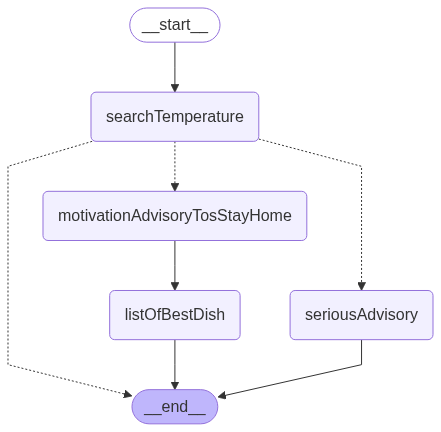

In [104]:
graph

In [113]:
result = graph.invoke({'city':"Karnataka"})
print(result['weatherType'])
print(result["advisory"])
print(result['listofSessionalDish'])

Rainy
Stay safe today! With rainy weather and a cool 20°C, it's best to stay home, avoid travel, and keep warm and dry. Rest, relax, and wait for clearer skies. Your safety matters!**Public Advisory:** Light rain expected with temperatures around 20°C. Carry an umbrella, drive carefully, and watch for slippery surfaces. Stay updated on local forecasts for any changes in weather conditions.
For a rainy day at 20°C, enjoy these comforting dishes:
- **Chicken Soup**: Warm and soothing.
- **Umnqusho**: Traditional and hearty.
- **Baked Potatoes**: Cozy and satisfying.


In [114]:
result = graph.invoke({'city':"Pune"})
print(result['weatherType'])
print(result["advisory"])
print(result['listofSessionalDish'])


Cloudy
Stay safe today! With cloudy skies and a warm 29°C, it's best to stay home, hydrate well, and avoid unnecessary outdoor activities. Protect your health and comfort indoors."Advisory: Cloudy conditions with a temperature of 29°C. Stay hydrated and monitor weather updates."
"Stay cool with these dishes on a cloudy day: **1. Salads**, **2. Grilled Chicken**, **3. Iced Tea**."
